# TNT Multi-Species: SAOS

**Objectives:**
- Fit TNT multi-species model to small-amplitude oscillatory shear data
- Understand multi-mode superposition in SAOS
- Decompose G' and G'' into per-species contributions
- Discuss spectrum resolution and data information content
- Compare NLSQ and Bayesian inference

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTMultiSpecies

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_epstein_saos,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_multi_species_param_names,
    plot_multi_species_spectrum,
    plot_mode_decomposition,
)

## Theory: Multi-Mode SAOS

For a multi-species TNT model, the storage and loss moduli are sums of Maxwell modes:

**Storage modulus:**
$$G'(\omega) = \sum_{i=0}^{N-1} G_i \frac{(\omega \tau_{b,i})^2}{1 + (\omega \tau_{b,i})^2}$$

**Loss modulus:**
$$G''(\omega) = \sum_{i=0}^{N-1} G_i \frac{\omega \tau_{b,i}}{1 + (\omega \tau_{b,i})^2} + \eta_s \omega$$

**Key physics:**
- Each species is a Maxwell mode: $G_i$ (modulus), $\tau_{b,i}$ (relaxation time)
- Fast species (short $\tau_{b,0}$): Dominates high frequency
- Slow species (long $\tau_{b,1}$): Dominates low frequency
- Multi-mode superposition broadens relaxation spectrum
- Solvent viscosity $\eta_s$ adds to loss modulus at all frequencies

**Crossover frequencies:**
- Species $i$ crossover: $\omega_i \sim 1/\tau_{b,i}$
- Below $\omega_i$: Liquid-like (G'' > G')
- Above $\omega_i$: Solid-like (G' > G'')

**Data requirements:**
- Need frequency range spanning both species crossovers
- Typical: ~3-4 decades to resolve 2 well-separated modes
- Limited data range → may not fully resolve all species

## Load Data

Data points: 19
Frequency range: 0.1008 to 99.42 rad/s
Frequency decades: 3.0
G' range: 8.28e+00 to 2.93e+03 Pa
G'' range: 2.78e+01 to 2.22e+03 Pa


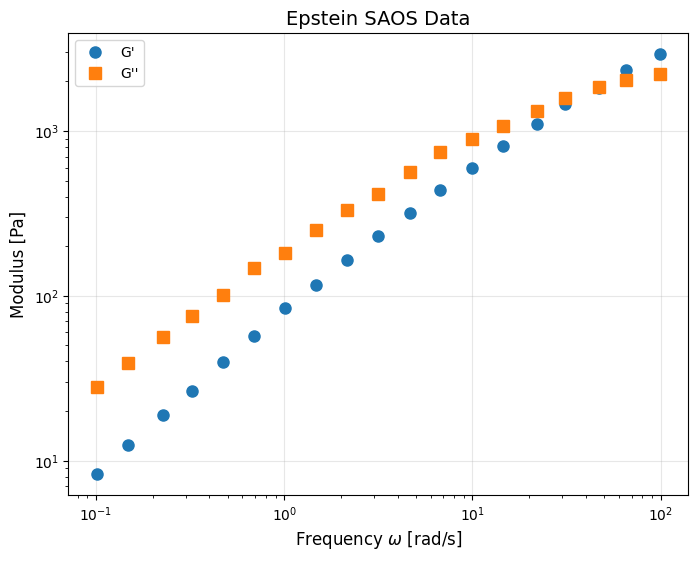

In [2]:
omega, G_prime, G_double_prime = load_epstein_saos()

# Compute complex modulus magnitude for fitting
G_star_mag = np.sqrt(G_prime**2 + G_double_prime**2)

print(f"Data points: {len(omega)}")
print(f"Frequency range: {omega.min():.4f} to {omega.max():.2f} rad/s")
print(f"Frequency decades: {np.log10(omega.max()/omega.min()):.1f}")
print(f"G' range: {G_prime.min():.2e} to {G_prime.max():.2e} Pa")
print(f"G'' range: {G_double_prime.min():.2e} to {G_double_prime.max():.2e} Pa")

fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(omega, G_prime, 'o', label="G'", markersize=8)
ax.loglog(omega, G_double_prime, 's', label="G''", markersize=8)
ax.set_xlabel(r'Frequency $\omega$ [rad/s]', fontsize=12)
ax.set_ylabel('Modulus [Pa]', fontsize=12)
ax.set_title('Epstein SAOS Data', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Data Information Content Discussion

**Important note on spectrum resolution:**

This dataset has **18 data points** spanning approximately **3 decades** in frequency. This is relatively sparse data for resolving two distinct relaxation modes.

**Identifiability considerations:**
- Two Maxwell modes require 4 parameters (G_0, tau_b_0, G_1, tau_b_1) plus eta_s = 5 total
- With 18 data points and log-scale sampling, we have limited information
- If the two species have similar relaxation times (tau_b_1/tau_b_0 < 10), they may be difficult to distinguish
- The fit may show **label switching** (species 0 ↔ species 1) or **parameter correlations**

**This is an intentional teaching point:**
- Demonstrates the importance of data quality and range
- Shows how Bayesian inference can reveal parameter uncertainty
- Illustrates practical limits of model identifiability
- Real-world scenarios often have limited data

For definitive multi-species resolution, ideally we would want:
- 4-5 decades frequency range
- Denser sampling (30-50 points)
- Multiple protocols (SAOS + relaxation + startup)

## NLSQ Fitting

In [3]:
model = TNTMultiSpecies(n_species=2)
param_names = get_tnt_multi_species_param_names(n_species=2)
print(f"Parameters: {param_names}")

start_time = time.time()
model.fit(omega, G_star_mag, test_mode="oscillation", method='scipy')
nlsq_time = time.time() - start_time

print(f"\nNLSQ converged: (check via model state)")
print(f"Optimization time: {nlsq_time:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    print(f"  {name}: {model.parameters.get_value(name):.6e}")

Parameters: ['G_0', 'tau_b_0', 'G_1', 'tau_b_1', 'eta_s']



NLSQ converged: (check via model state)
Optimization time: 0.91 s

Fitted parameters:
  G_0: 1.326629e+02
  tau_b_0: 1.047500e+00
  G_1: 1.394642e+03
  tau_b_1: 6.688606e-02
  eta_s: 3.429617e+01



Fit quality (G* magnitude):
  R² = 0.994045
  RMSE = 8.533737e+01
  NRMSE = 0.023410


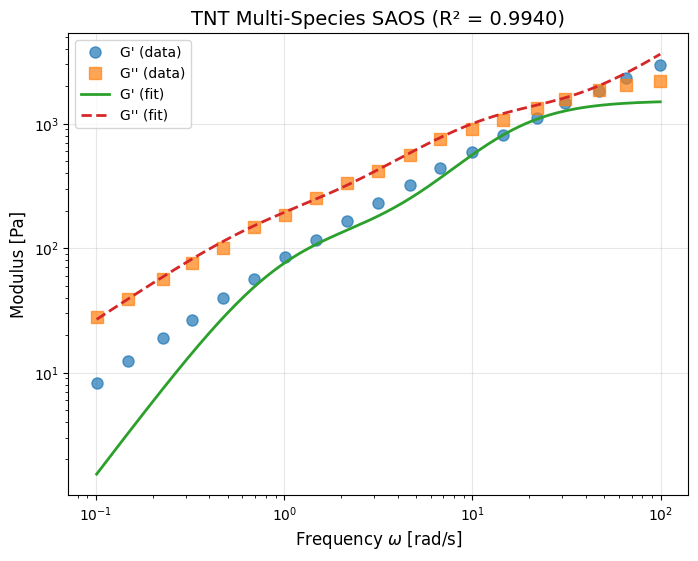

In [4]:
omega_pred = np.logspace(np.log10(omega.min()), np.log10(omega.max()), 200)
G_prime_pred, G_double_prime_pred = model.predict_saos(omega_pred)
G_prime_fit, G_double_prime_fit = model.predict_saos(omega)
G_star_mag_fit = np.sqrt(G_prime_fit**2 + G_double_prime_fit**2)

fit_metrics = compute_fit_quality(G_star_mag, G_star_mag_fit)
print(f"\nFit quality (G* magnitude):")
print(f"  R² = {fit_metrics['R2']:.6f}")
print(f"  RMSE = {fit_metrics['RMSE']:.6e}")
print(f"  NRMSE = {fit_metrics['NRMSE']:.6f}")

fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(omega, G_prime, 'o', label="G' (data)", markersize=8, alpha=0.7)
ax.loglog(omega, G_double_prime, 's', label="G'' (data)", markersize=8, alpha=0.7)
ax.loglog(omega_pred, G_prime_pred, '-', label="G' (fit)", linewidth=2)
ax.loglog(omega_pred, G_double_prime_pred, '--', label="G'' (fit)", linewidth=2)
ax.set_xlabel(r'Frequency $\omega$ [rad/s]', fontsize=12)
ax.set_ylabel('Modulus [Pa]', fontsize=12)
ax.set_title(f'TNT Multi-Species SAOS (R² = {fit_metrics['R2']:.4f})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Physical Analysis: Per-Species Moduli Decomposition

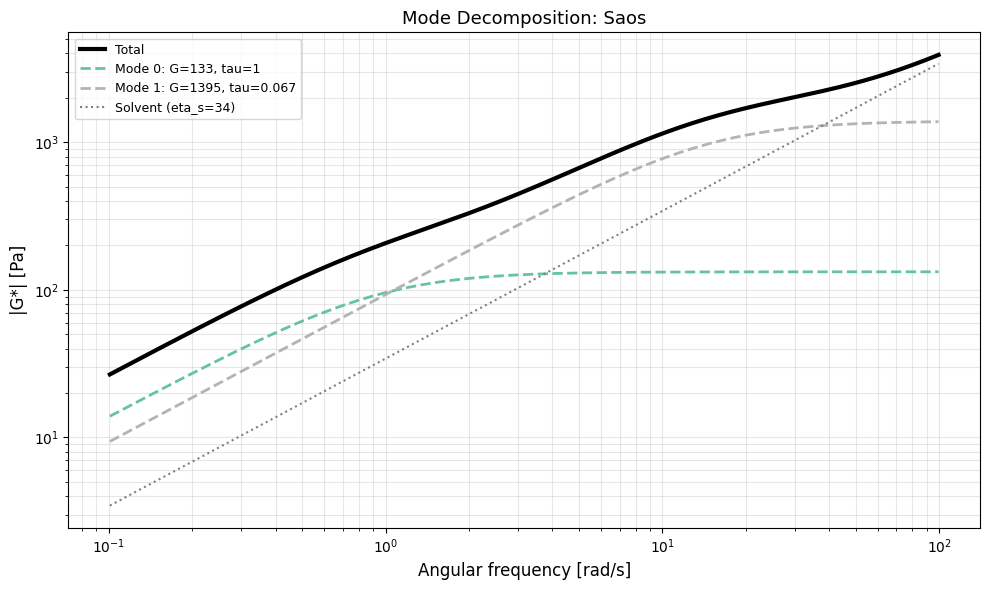


Per-species SAOS contributions:

Species 0 (fast):
  G_0 = 1.327e+02 Pa
  tau_b_0 = 1.047e+00 s
  Crossover frequency ~ 1/tau_b_0 = 9.547e-01 rad/s
  Dominates high frequency (ω >> 1/tau_b_0)

Species 1 (slow):
  G_1 = 1.395e+03 Pa
  tau_b_1 = 6.689e-02 s
  Crossover frequency ~ 1/tau_b_1 = 1.495e+01 rad/s
  Dominates low frequency (ω << 1/tau_b_0)

Solvent viscosity:
  eta_s = 3.430e+01 Pa·s
  Contributes to G'' at all frequencies

Timescale separation:
  tau_b_1/tau_b_0 = 0.06
  Crossover separation: -1.2 decades


In [5]:
fig = plot_mode_decomposition(model, omega_pred, "saos")
plt.show()
plt.close('all')

G_0 = model.parameters.get_value('G_0')
tau_b_0 = model.parameters.get_value('tau_b_0')
G_1 = model.parameters.get_value('G_1')
tau_b_1 = model.parameters.get_value('tau_b_1')
eta_s = model.parameters.get_value('eta_s')

print("\nPer-species SAOS contributions:")
print(f"\nSpecies 0 (fast):")
print(f"  G_0 = {G_0:.3e} Pa")
print(f"  tau_b_0 = {tau_b_0:.3e} s")
print(f"  Crossover frequency ~ 1/tau_b_0 = {1/tau_b_0:.3e} rad/s")
print(f"  Dominates high frequency (ω >> 1/tau_b_0)")

print(f"\nSpecies 1 (slow):")
print(f"  G_1 = {G_1:.3e} Pa")
print(f"  tau_b_1 = {tau_b_1:.3e} s")
print(f"  Crossover frequency ~ 1/tau_b_1 = {1/tau_b_1:.3e} rad/s")
print(f"  Dominates low frequency (ω << 1/tau_b_0)")

print(f"\nSolvent viscosity:")
print(f"  eta_s = {eta_s:.3e} Pa·s")
print(f"  Contributes to G'' at all frequencies")

print(f"\nTimescale separation:")
print(f"  tau_b_1/tau_b_0 = {tau_b_1/tau_b_0:.2f}")
print(f"  Crossover separation: {np.log10(tau_b_1/tau_b_0):.1f} decades")

## Discrete Relaxation Spectrum

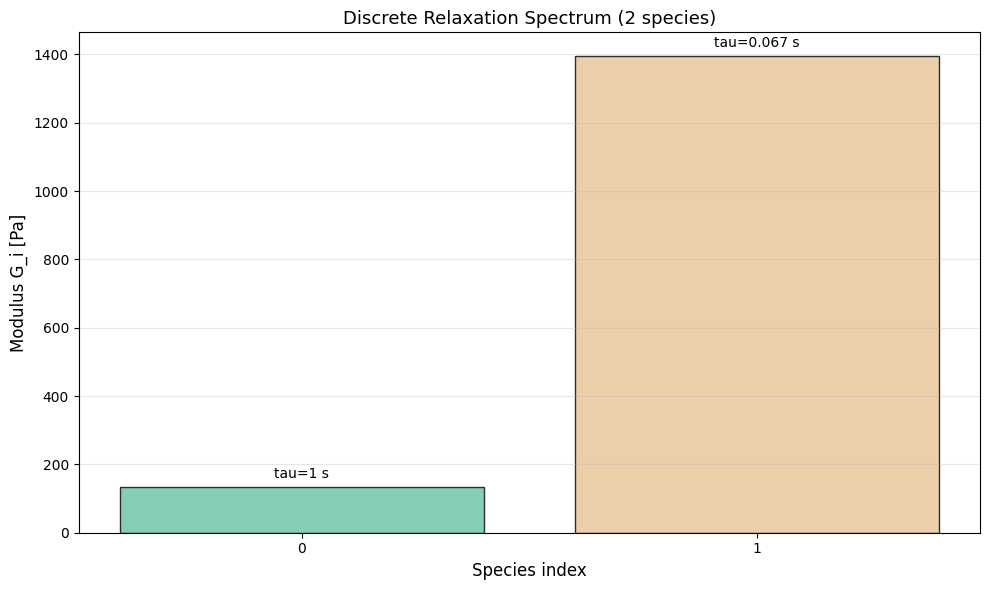


Spectrum interpretation:
- Two discrete relaxation times (Maxwell modes)
- Fast mode contributes at high frequencies
- Slow mode contributes at low frequencies
- Broader spectrum than single Maxwell mode
- No intermediate modes (discrete, not continuous)


In [6]:
fig = plot_multi_species_spectrum(model)
plt.show()
plt.close('all')

print("\nSpectrum interpretation:")
print("- Two discrete relaxation times (Maxwell modes)")
print("- Fast mode contributes at high frequencies")
print("- Slow mode contributes at low frequencies")
print("- Broader spectrum than single Maxwell mode")
print("- No intermediate modes (discrete, not continuous)")

## Information Content Analysis

In [7]:
print("\nData information content assessment:")
print(f"\nFrequency window: {omega.min():.3e} to {omega.max():.3e} rad/s")
print(f"  ({np.log10(omega.max()/omega.min()):.1f} decades)")
print(f"\nFitted crossover frequencies:")
print(f"  1/tau_b_0 = {1/tau_b_0:.3e} rad/s (fast)")
print(f"  1/tau_b_1 = {1/tau_b_1:.3e} rad/s (slow)")

# Check if crossovers are within data window
omega_min, omega_max = omega.min(), omega.max()
omega_cross_0 = 1/tau_b_0
omega_cross_1 = 1/tau_b_1

print(f"\nCrossover resolution:")
if omega_cross_0 >= omega_min and omega_cross_0 <= omega_max:
    print(f"  Fast species: RESOLVED (crossover within data)")
else:
    print(f"  Fast species: EXTRAPOLATED (crossover outside data)")

if omega_cross_1 >= omega_min and omega_cross_1 <= omega_max:
    print(f"  Slow species: RESOLVED (crossover within data)")
else:
    print(f"  Slow species: EXTRAPOLATED (crossover outside data)")

print(f"\nIdentifiability assessment:")
print(f"  Data points: {len(omega)}")
print(f"  Model parameters: 5 (G_0, tau_b_0, G_1, tau_b_1, eta_s)")
print(f"  Data/parameter ratio: {len(omega)/5:.1f}")

if tau_b_1/tau_b_0 < 3:
    print(f"\n  WARNING: Timescales too close (ratio = {tau_b_1/tau_b_0:.1f})")
    print(f"  → Species may be difficult to distinguish")
    print(f"  → Expect large parameter uncertainties and correlations")
elif tau_b_1/tau_b_0 < 10:
    print(f"\n  MODERATE: Timescale separation = {tau_b_1/tau_b_0:.1f}")
    print(f"  → Species moderately resolvable with this data")
    print(f"  → Some parameter uncertainty expected")
else:
    print(f"\n  GOOD: Timescale separation = {tau_b_1/tau_b_0:.1f}")
    print(f"  → Species well separated, clearly identifiable")

print(f"\nNote: 18 data points over ~3 decades is relatively sparse.")
print(f"For robust multi-species resolution, ideally:")
print(f"  - 4-5 decades frequency range")
print(f"  - 30-50 data points")
print(f"  - Complementary protocols (relaxation, startup)")


Data information content assessment:

Frequency window: 1.008e-01 to 9.942e+01 rad/s
  (3.0 decades)

Fitted crossover frequencies:
  1/tau_b_0 = 9.547e-01 rad/s (fast)
  1/tau_b_1 = 1.495e+01 rad/s (slow)

Crossover resolution:
  Fast species: RESOLVED (crossover within data)
  Slow species: RESOLVED (crossover within data)

Identifiability assessment:
  Data points: 19
  Model parameters: 5 (G_0, tau_b_0, G_1, tau_b_1, eta_s)
  Data/parameter ratio: 3.8

  → Species may be difficult to distinguish
  → Expect large parameter uncertainties and correlations

Note: 18 data points over ~3 decades is relatively sparse.
For robust multi-species resolution, ideally:
  - 4-5 decades frequency range
  - 30-50 data points
  - Complementary protocols (relaxation, startup)


## Bayesian Inference

In [8]:
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running Bayesian inference with {NUM_CHAINS} chain(s)...")
print(f"Note: Expect potential label switching and parameter correlations.")
start_time = time.time()
result_bayes = model.fit_bayesian(
    omega,
    G_star_mag,
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    seed=42,
)
bayes_time = time.time() - start_time
print(f"Bayesian inference time: {bayes_time:.2f} s")

Running Bayesian inference with 1 chain(s)...
Note: Expect potential label switching and parameter correlations.


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<14:47,  1.27s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:  10%|▉         | 68/700 [00:01<00:09, 68.15it/s, 35 steps of size 5.85e-03. acc. prob=0.94]

warmup:  15%|█▌        | 106/700 [00:01<00:05, 101.18it/s, 63 steps of size 3.78e-02. acc. prob=0.95]

warmup:  20%|█▉        | 139/700 [00:01<00:04, 133.39it/s, 39 steps of size 3.86e-02. acc. prob=0.96]

warmup:  26%|██▌       | 183/700 [00:01<00:02, 185.06it/s, 87 steps of size 3.39e-02. acc. prob=0.96]

sample:  35%|███▌      | 246/700 [00:01<00:01, 271.47it/s, 127 steps of size 3.62e-02. acc. prob=0.99]

sample:  45%|████▍     | 312/700 [00:01<00:01, 355.24it/s, 191 steps of size 3.62e-02. acc. prob=0.99]

sample:  59%|█████▉    | 416/700 [00:02<00:00, 516.86it/s, 79 steps of size 3.62e-02. acc. prob=0.99] 

sample:  69%|██████▉   | 485/700 [00:02<00:00, 544.15it/s, 47 steps of size 3.62e-02. acc. prob=0.99]

sample:  82%|████████▏ | 575/700 [00:02<00:00, 634.16it/s, 63 steps of size 3.62e-02. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [00:02<00:00, 661.05it/s, 127 steps of size 3.62e-02. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:02<00:00, 290.97it/s, 127 steps of size 3.62e-02. acc. prob=0.99]

Bayesian inference time: 6.13 s


## Convergence Diagnostics

In [9]:
print_convergence_summary(result_bayes, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    1.0000       500      PASS
        tau_b_0    1.0000       500      PASS
            G_1    1.0000       500      PASS
        tau_b_1    1.0000       500      PASS
          eta_s    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


True

## ArviZ Diagnostics: Trace Plots

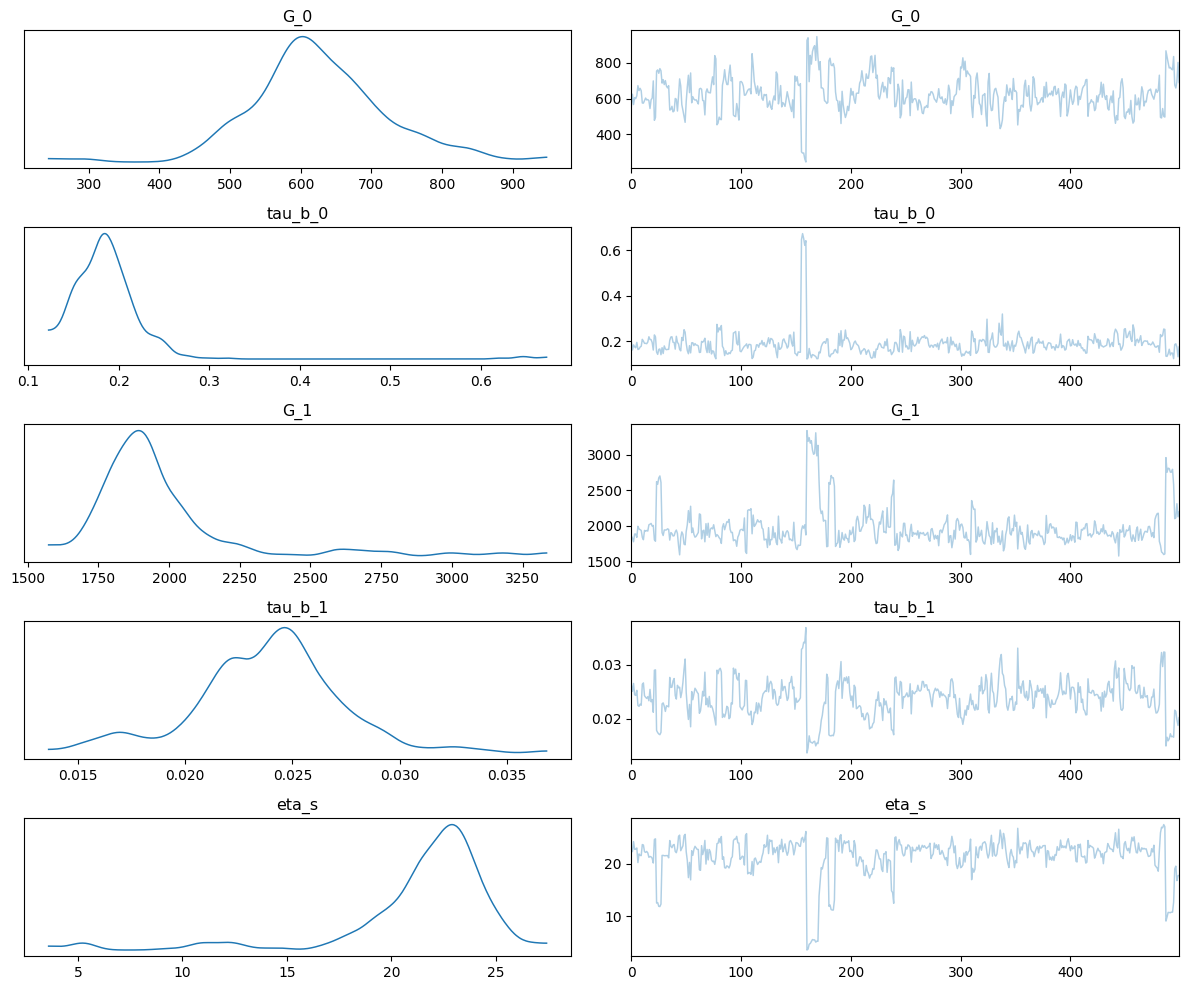

In [10]:
idata = az.from_dict(posterior={name: result_bayes.posterior_samples[name][None, :] for name in param_names})
axes = az.plot_trace(idata, var_names=param_names, compact=True)
plt.tight_layout()
plt.show()
plt.close('all')

## ArviZ Diagnostics: Posterior Distributions

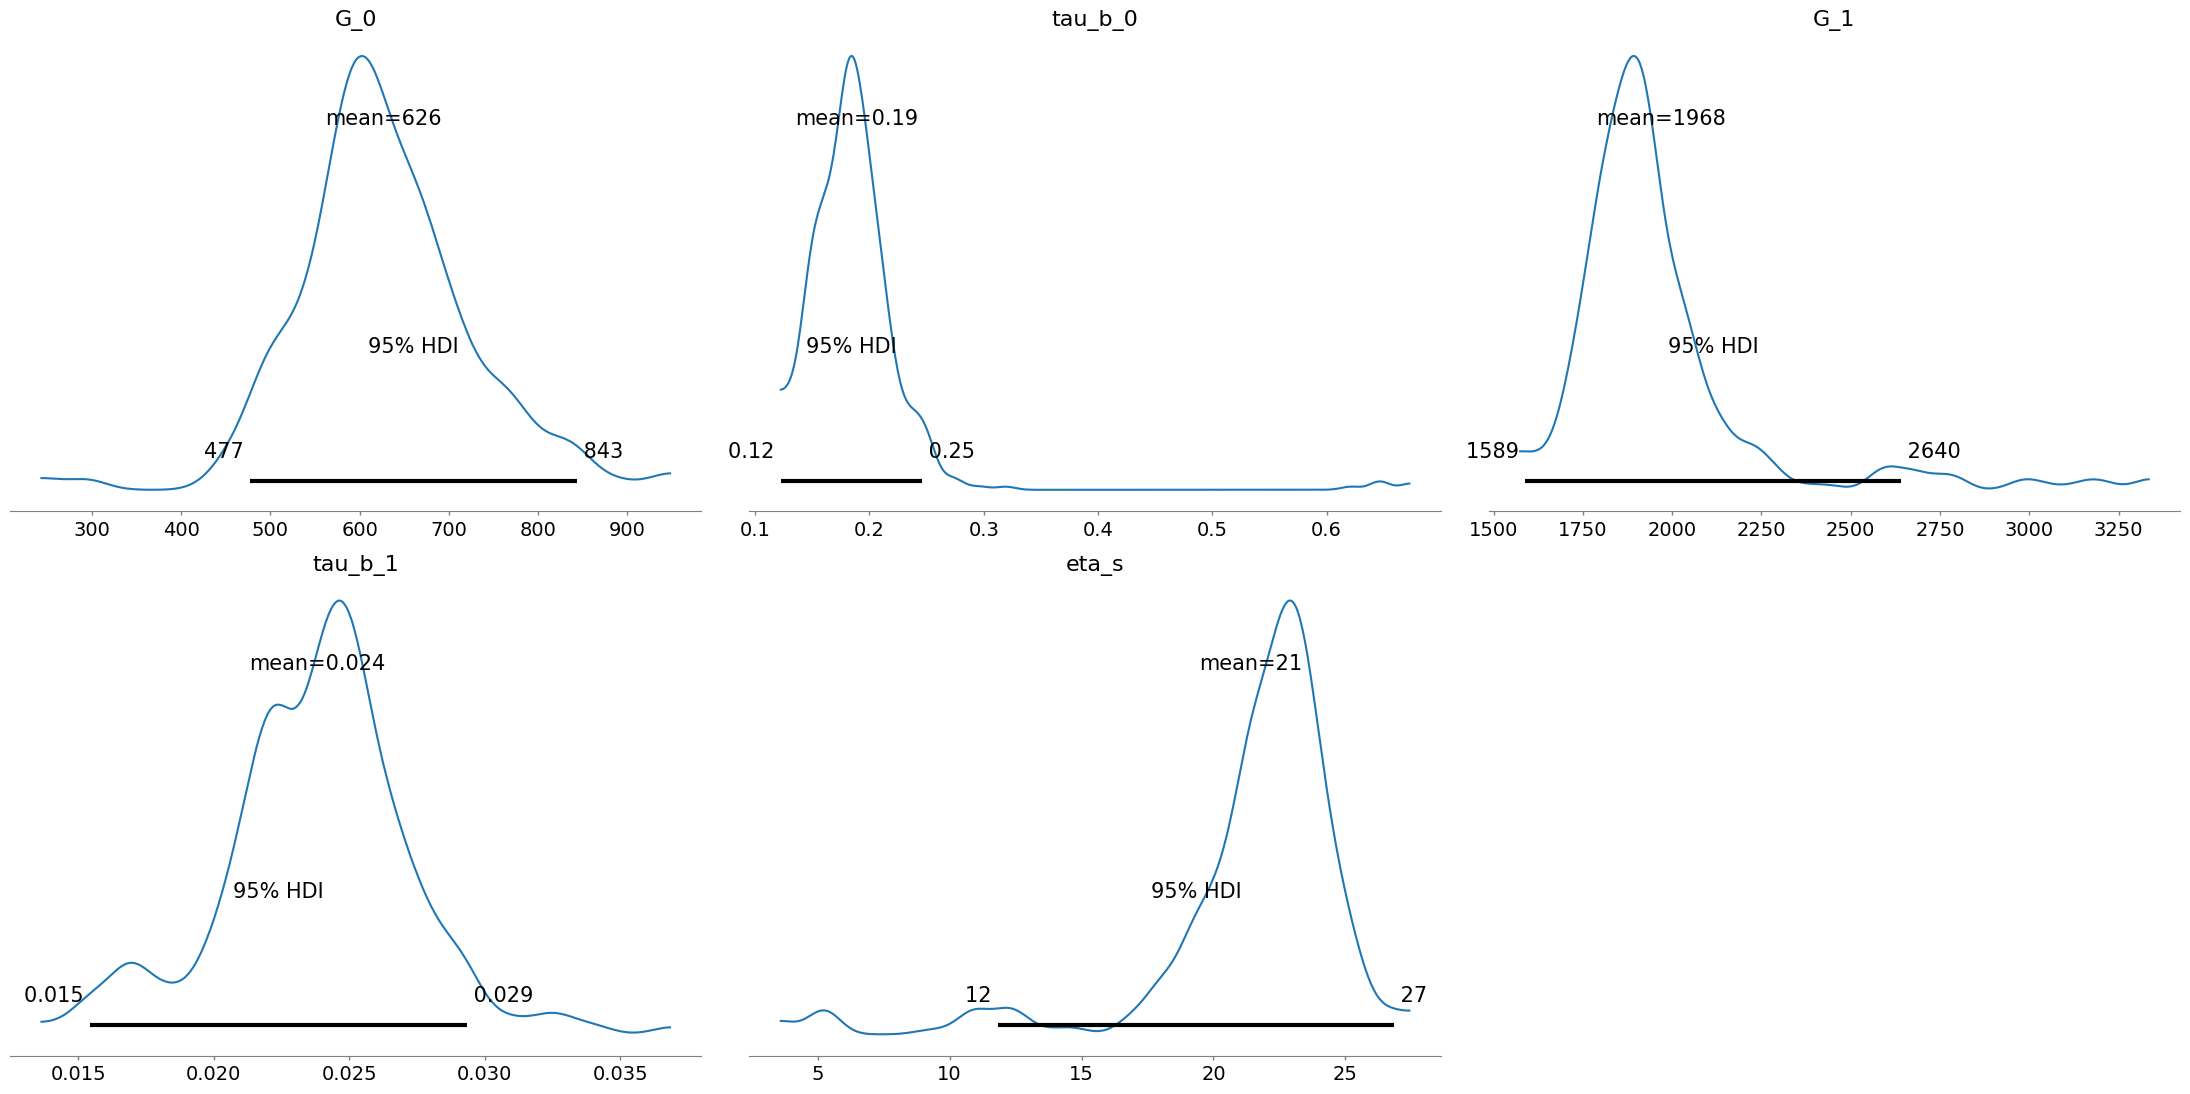

In [11]:
fig = az.plot_posterior(idata, var_names=param_names, hdi_prob=0.95)
plt.tight_layout()
plt.show()
plt.close('all')

## ArviZ Diagnostics: Pair Plot (Correlations)

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/pairplot.py:229: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


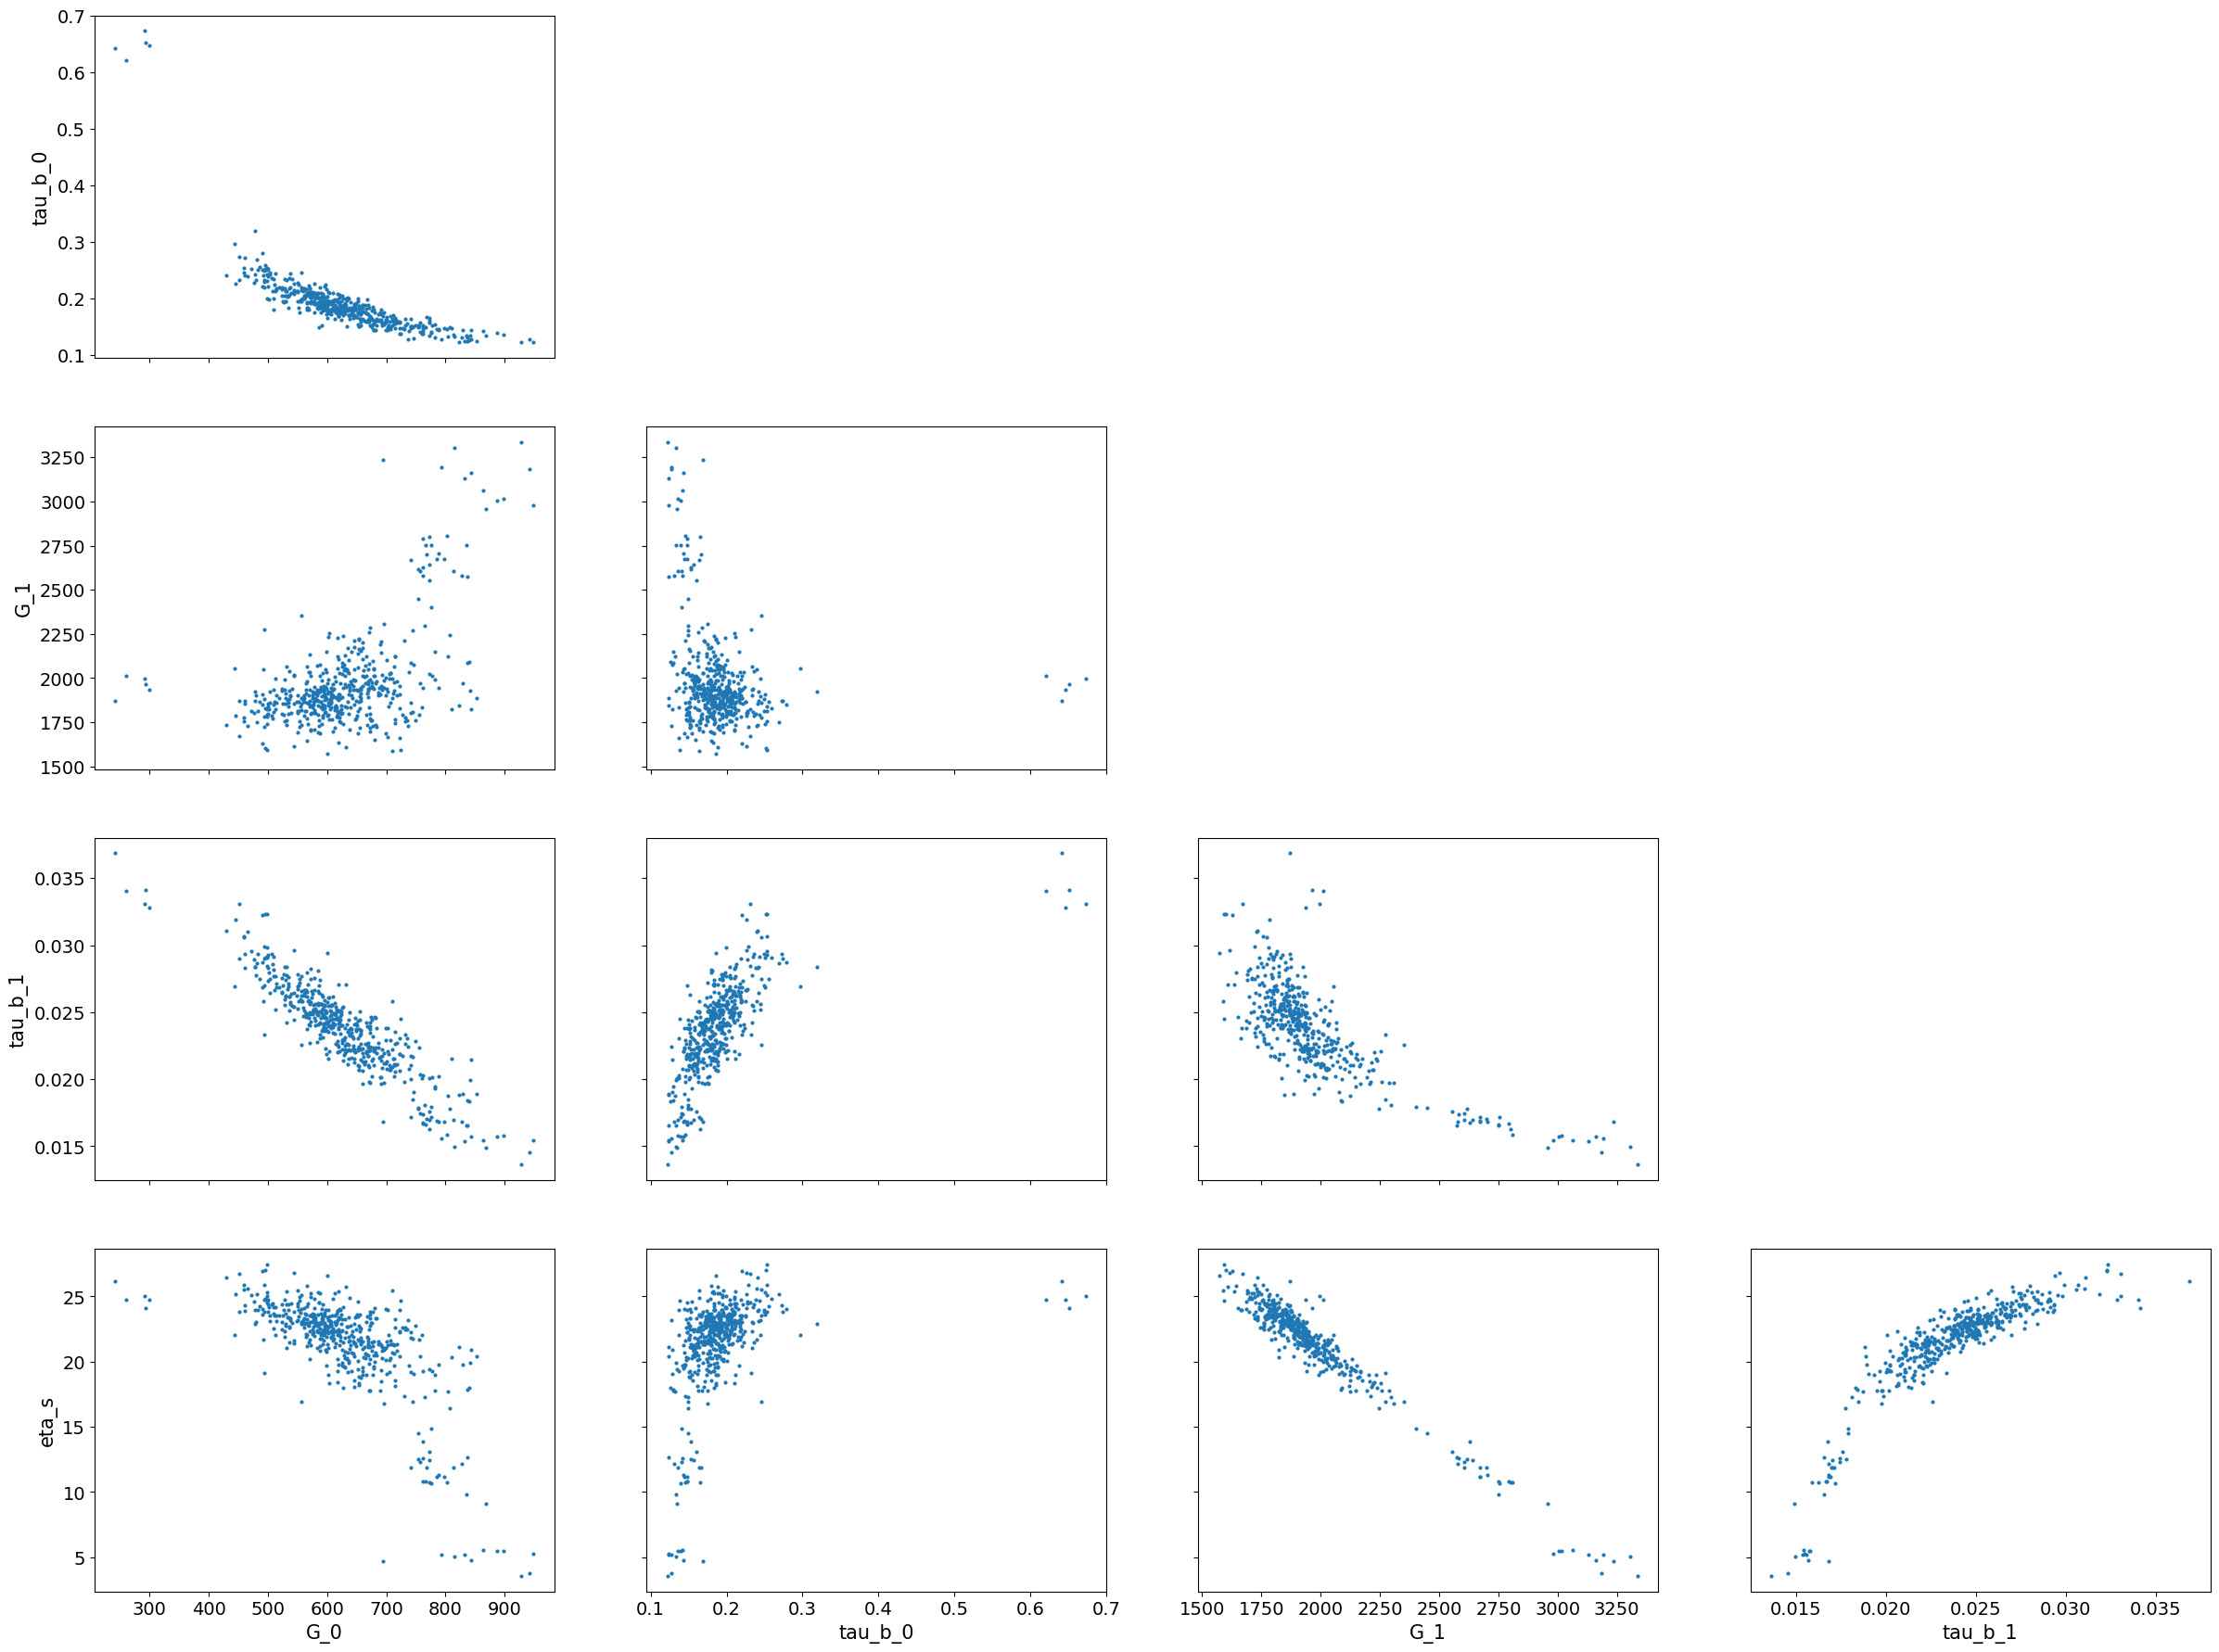


Expected correlations:
- G_0 and tau_b_0 may be correlated (species 0 trade-off)
- G_1 and tau_b_1 may be correlated (species 1 trade-off)
- If timescales too close, may see label switching (G_0 ↔ G_1, tau_b_0 ↔ tau_b_1)
- Bimodal posteriors indicate non-identifiability


In [12]:
axes = az.plot_pair(idata, var_names=param_names, divergences=True)
plt.show()
plt.close('all')

print("\nExpected correlations:")
print("- G_0 and tau_b_0 may be correlated (species 0 trade-off)")
print("- G_1 and tau_b_1 may be correlated (species 1 trade-off)")
print("- If timescales too close, may see label switching (G_0 ↔ G_1, tau_b_0 ↔ tau_b_1)")
print("- Bimodal posteriors indicate non-identifiability")

## NLSQ vs Bayesian Parameter Comparison

In [13]:
print_parameter_comparison(model, result_bayes.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0         132.7         617.6  [461.4, 836.4]
        tau_b_0         1.047        0.1833  [0.1302, 0.2545]
            G_1          1395          1905  [1669, 2805]
        tau_b_1       0.06689       0.02405  [0.01639, 0.03063]
          eta_s          34.3         22.32  [10.25, 25.57]


## Posterior Predictive: SAOS Moduli

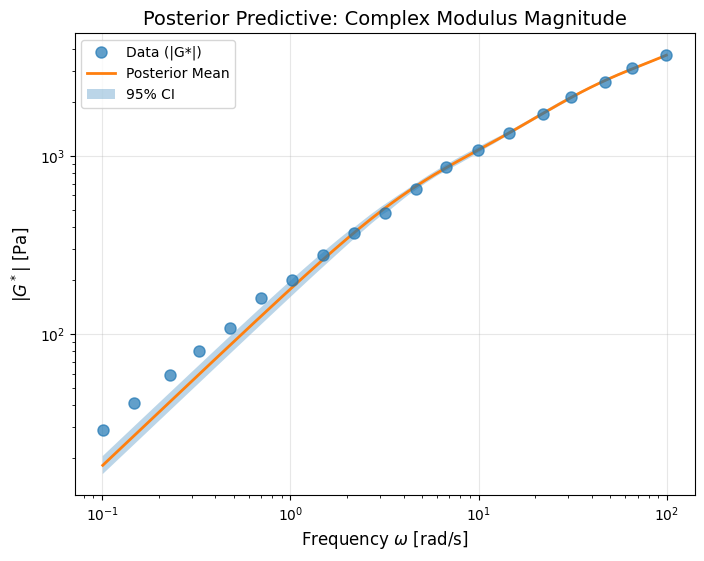

In [14]:
posterior = result_bayes.posterior_samples
n_draws = min(200, NUM_SAMPLES)
draw_indices = np.linspace(0, NUM_SAMPLES - 1, n_draws, dtype=int)

x_pred = omega_pred
y_pred_samples = []

for i in draw_indices:
    # Set parameters from posterior draw
    for name in param_names:
        model.parameters.set_value(name, posterior[name][i])
    # Predict with current parameters
    G_prime_i, G_double_prime_i = model.predict_saos(x_pred)
    G_star_mag_i = np.sqrt(G_prime_i**2 + G_double_prime_i**2)
    y_pred_samples.append(np.array(G_star_mag_i))

y_pred_samples = np.array(y_pred_samples)
y_pred_mean = np.mean(y_pred_samples, axis=0)
y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=0)
y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(omega, G_star_mag, 'o', label='Data (|G*|)', markersize=8, alpha=0.7, zorder=3)
ax.loglog(omega_pred, y_pred_mean, '-', label='Posterior Mean', linewidth=2, zorder=2)
ax.fill_between(omega_pred, y_pred_lower, y_pred_upper, alpha=0.3, label='95% CI', zorder=1)
ax.set_xlabel(r'Frequency $\omega$ [rad/s]', fontsize=12)
ax.set_ylabel(r'$|G^*|$ [Pa]', fontsize=12)
ax.set_title('Posterior Predictive: Complex Modulus Magnitude', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Physical Interpretation

**Multi-mode SAOS:**
- Two Maxwell modes broaden the relaxation spectrum
- Fast species dominates high frequency (short-time relaxation)
- Slow species dominates low frequency (long-time relaxation)
- Crossover frequencies ~ $1/\tau_{b,i}$ separate regimes

**Spectrum resolution challenges:**
- Limited data range (3 decades) constrains resolution
- 18 data points for 5 parameters → modest information content
- Close timescales → parameter correlations and trade-offs
- Bayesian posteriors reveal uncertainty structure

**Uncertainty quantification:**
- Wide credible intervals indicate limited identifiability
- Parameter correlations suggest species may trade off in fitting
- Predictive uncertainty reflects data limitations
- More data (frequency range, complementary protocols) would improve resolution

## Save Results

In [15]:
save_tnt_results(model, result_bayes, "multi_species", "saos", param_names)
print("Results saved successfully.")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/multi_species/saos/
  nlsq_params_saos.json: 5 parameters
  posterior_saos.json: 500 draws
Results saved successfully.


## Key Takeaways

1. **Multi-mode superposition**: G' and G'' are sums of Maxwell mode contributions
2. **Frequency-dependent dominance**: Fast species (high ω), slow species (low ω)
3. **Crossover frequencies**: Species relaxation times control transitions
4. **Spectrum broadening**: Multi-species captures wider range than single mode
5. **Data information content**: Limited data range constrains parameter resolution
6. **Identifiability limits**: Close timescales → parameter correlations and uncertainty
7. **Bayesian inference**: Reveals uncertainty structure and need for more data
8. **Practical lesson**: Real-world data often has limitations; understand what you can and cannot resolve